Ghana Maize Yield Prediction - Model Training
## Objective
# This notebook trains and compares multiple machine learning models:
# - Baseline Models (Linear Regression, Ridge, Lasso)
# - Tree-Based Models (Random Forest, XGBoost, LightGBM)
# - Ensemble Models
# 
# We'll evaluate models using:
# - R² Score
# - RMSE (Root Mean Square Error)
# - MAE (Mean Absolute Error)
# - MAPE (Mean Absolute Percentage Error)

## 1. Setup and Data Loading

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime

# Scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


In [21]:
# Load processed data
data_dir = Path('../data/processed')

# Load unscaled data (for tree-based models)
train_df = pd.read_csv(data_dir / 'train.csv')
val_df = pd.read_csv(data_dir / 'validation.csv')
test_df = pd.read_csv(data_dir / 'test.csv')

# Load scaled data (for linear models)
train_scaled = pd.read_csv(data_dir / 'train_scaled.csv')
val_scaled = pd.read_csv(data_dir / 'validation_scaled.csv')
test_scaled = pd.read_csv(data_dir / 'test_scaled.csv')

print("Data loaded successfully!")
print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

Data loaded successfully!
Training set: 1,241 samples
Validation set: 355 samples
Test set: 178 samples


## 2. Feature Selection and Preparation

In [22]:
# Define feature sets
print("=" * 80)
print("FEATURE SELECTION")
print("=" * 80)

# Features to exclude (non-predictive or target)
exclude_features = ['District', 'Year', 'Yield', 'Soil_Type']

# Get all available features
all_features = [col for col in train_df.columns if col not in exclude_features]

# Core environmental features
core_features = ['Rainfall', 'Temperature', 'Humidity', 'Sunlight', 'Soil_Moisture']

# Policy and lag features
policy_features = ['PFJ_Policy', 'Pest_Risk', 'Yield_Lag1']

# Engineered features
engineered_features = [
    'Growing_Degree_Days', 'Water_Availability', 'Climate_Stress',
    'Moisture_Temp_Ratio', 'Rainfall_per_Sun', 'Years_Since_PFJ'
]

# Full feature set
feature_sets = {
    'core_only': core_features,
    'core_plus_policy': core_features + policy_features,
    'all_features': all_features
}

print(f"\nTotal available features: {len(all_features)}")
print(f"\nFeature breakdown:")
print(f"  - Core environmental: {len(core_features)}")
print(f"  - Policy & lag: {len(policy_features)}")
print(f"  - Engineered: {len(engineered_features)}")

print(f"\nUsing 'all_features' set: {len(all_features)} features")
print("\nFeatures:")
for i, feat in enumerate(all_features, 1):
    print(f"  {i:2d}. {feat}")


FEATURE SELECTION

Total available features: 19

Feature breakdown:
  - Core environmental: 5
  - Policy & lag: 3
  - Engineered: 6

Using 'all_features' set: 19 features

Features:
   1. Rainfall
   2. Temperature
   3. Humidity
   4. Sunlight
   5. Soil_Moisture
   6. Pest_Risk
   7. PFJ_Policy
   8. Yield_Lag1
   9. Growing_Degree_Days
  10. Water_Availability
  11. Climate_Stress
  12. Moisture_Temp_Ratio
  13. Rainfall_per_Sun
  14. Years_Since_PFJ
  15. Temp_Sun_Interaction
  16. Rainfall_per_Moisture
  17. Pest_Soil_Risk
  18. Yield_Change
  19. Yield_Growth_Rate


In [23]:
# Prepare X and y for modeling
features = all_features

# For tree-based models (unscaled)
X_train = train_df[features]
y_train = train_df['Yield']
X_val = val_df[features]
y_val = val_df['Yield']
X_test = test_df[features]
y_test = test_df['Yield']

# For linear models (scaled)
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['Yield']
X_val_scaled = val_scaled[features]
y_val_scaled = val_scaled['Yield']
X_test_scaled = test_scaled[features]
y_test_scaled = test_scaled['Yield']

print(f"\nFeature matrices prepared")
print(f"Training: X{X_train.shape}, y{y_train.shape}")
print(f"Validation: X{X_val.shape}, y{y_val.shape}")
print(f"Test: X{X_test.shape}, y{y_test.shape}")



Feature matrices prepared
Training: X(1241, 19), y(1241,)
Validation: X(355, 19), y(355,)
Test: X(178, 19), y(178,)


## 3. Evaluation Metrics

In [24]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive evaluation metrics.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        model_name: Name of the model
    
    Returns:
        Dictionary of metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    return metrics

def print_metrics(metrics):
    """Pretty print metrics."""
    print(f"\n{'Model':<30} {'RMSE':<12} {'MAE':<12} {'R²':<12} {'MAPE':<12}")
    print("=" * 80)
    print(f"{metrics['Model']:<30} {metrics['RMSE']:<12.4f} {metrics['MAE']:<12.4f} "
          f"{metrics['R2']:<12.4f} {metrics['MAPE']:<12.2f}%")


## 4. Baseline Models

In [25]:
print("=" * 80)
print("TRAINING BASELINE MODELS")
print("=" * 80)

baseline_results = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)

lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)

lr_train_metrics = evaluate_model(y_train_scaled, lr_train_pred, "Linear Regression (Train)")
lr_val_metrics = evaluate_model(y_val_scaled, lr_val_pred, "Linear Regression (Val)")

print_metrics(lr_train_metrics)
print_metrics(lr_val_metrics)
baseline_results.extend([lr_train_metrics, lr_val_metrics])

# 2. Ridge Regression
print("\n2. Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train_scaled, y_train_scaled)

ridge_train_pred = ridge_model.predict(X_train_scaled)
ridge_val_pred = ridge_model.predict(X_val_scaled)

ridge_train_metrics = evaluate_model(y_train_scaled, ridge_train_pred, "Ridge (Train)")
ridge_val_metrics = evaluate_model(y_val_scaled, ridge_val_pred, "Ridge (Val)")

print_metrics(ridge_train_metrics)
print_metrics(ridge_val_metrics)
baseline_results.extend([ridge_train_metrics, ridge_val_metrics])

# 3. Lasso Regression
print("\n3. Training Lasso Regression...")
lasso_model = Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_scaled)

lasso_train_pred = lasso_model.predict(X_train_scaled)
lasso_val_pred = lasso_model.predict(X_val_scaled)

lasso_train_metrics = evaluate_model(y_train_scaled, lasso_train_pred, "Lasso (Train)")
lasso_val_metrics = evaluate_model(y_val_scaled, lasso_val_pred, "Lasso (Val)")

print_metrics(lasso_train_metrics)
print_metrics(lasso_val_metrics)
baseline_results.extend([lasso_train_metrics, lasso_val_metrics])

TRAINING BASELINE MODELS

1. Training Linear Regression...

Model                          RMSE         MAE          R²           MAPE        
Linear Regression (Train)      0.2656       0.1709       0.7451       10.05       %

Model                          RMSE         MAE          R²           MAPE        
Linear Regression (Val)        0.2419       0.1595       0.7939       9.09        %

2. Training Ridge Regression...

Model                          RMSE         MAE          R²           MAPE        
Ridge (Train)                  0.2661       0.1703       0.7441       10.03       %

Model                          RMSE         MAE          R²           MAPE        
Ridge (Val)                    0.2422       0.1584       0.7934       9.05        %

3. Training Lasso Regression...

Model                          RMSE         MAE          R²           MAPE        
Lasso (Train)                  0.2693       0.1730       0.7380       10.24       %

Model                          RMS

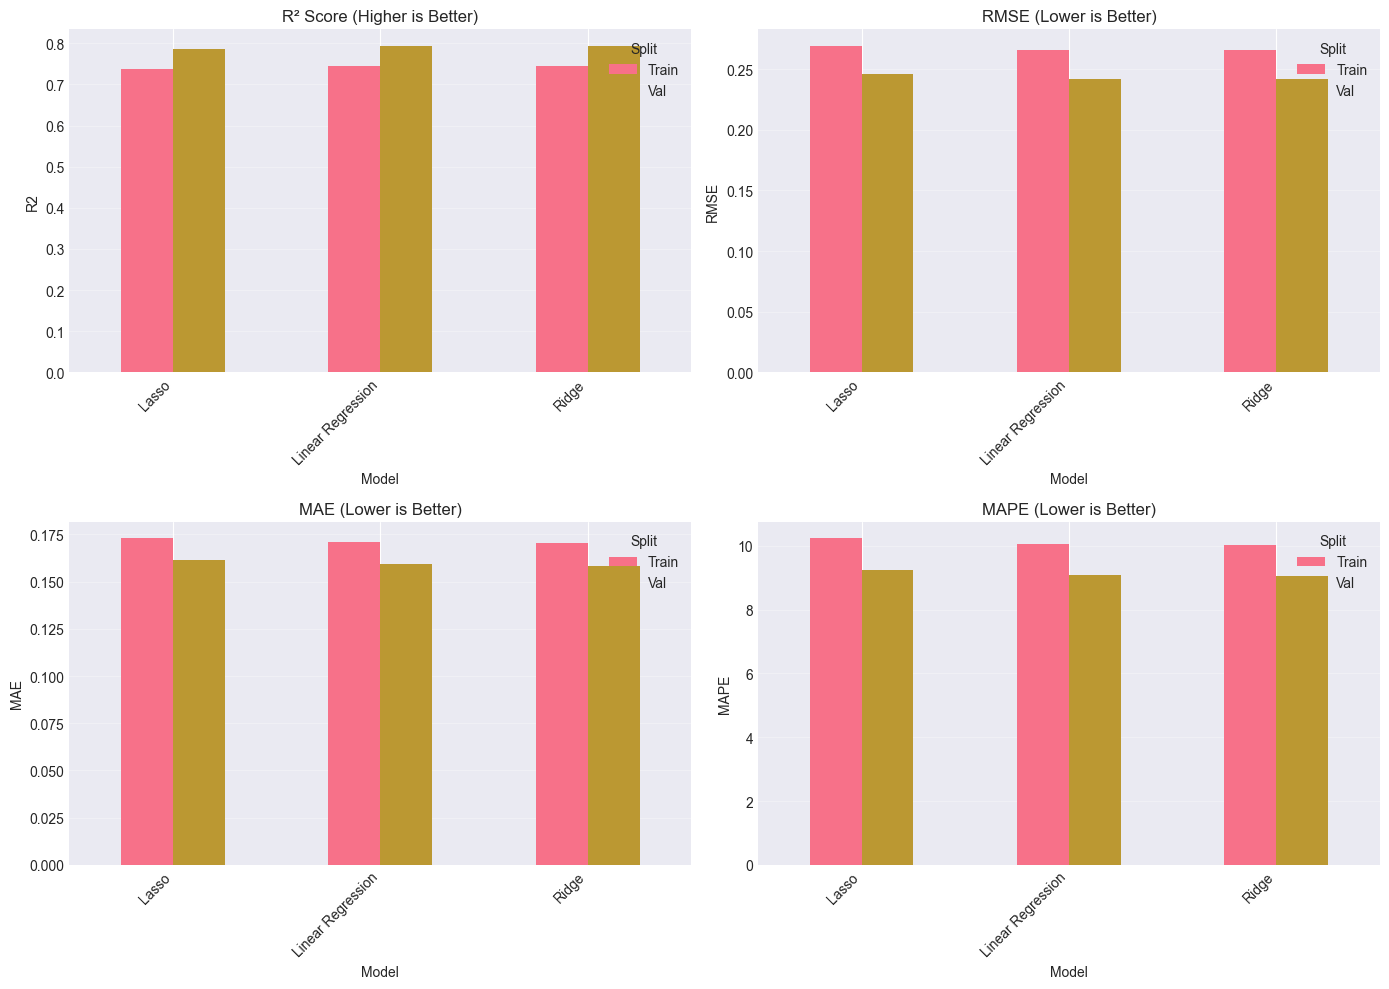

In [26]:
# Visualize baseline results
baseline_df = pd.DataFrame(baseline_results)
baseline_df['Split'] = baseline_df['Model'].str.extract(r'\((Train|Val)\)')[0]
baseline_df['Model_Name'] = baseline_df['Model'].str.replace(r'\s*\(.*\)', '', regex=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['R2', 'RMSE', 'MAE', 'MAPE']
titles = ['R² Score (Higher is Better)', 'RMSE (Lower is Better)', 
          'MAE (Lower is Better)', 'MAPE (Lower is Better)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    pivot_data = baseline_df.pivot(index='Model_Name', columns='Split', values=metric)
    pivot_data.plot(kind='bar', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.legend(title='Split')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 5. Tree-Based Models

In [27]:
print("=" * 80)
print("TRAINING TREE-BASED MODELS")
print("=" * 80)

tree_results = []

# 1. Decision Tree
print("\n1. Training Decision Tree...")
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)
dt_model.fit(X_train, y_train)

dt_train_pred = dt_model.predict(X_train)
dt_val_pred = dt_model.predict(X_val)

dt_train_metrics = evaluate_model(y_train, dt_train_pred, "Decision Tree (Train)")
dt_val_metrics = evaluate_model(y_val, dt_val_pred, "Decision Tree (Val)")

print_metrics(dt_train_metrics)
print_metrics(dt_val_metrics)
tree_results.extend([dt_train_metrics, dt_val_metrics])

# 2. Random Forest
print("\n2. Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)

rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest (Train)")
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest (Val)")

print_metrics(rf_train_metrics)
print_metrics(rf_val_metrics)
tree_results.extend([rf_train_metrics, rf_val_metrics])

# 3. Gradient Boosting
print("\n3. Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)
gb_model.fit(X_train, y_train)

gb_train_pred = gb_model.predict(X_train)
gb_val_pred = gb_model.predict(X_val)

gb_train_metrics = evaluate_model(y_train, gb_train_pred, "Gradient Boosting (Train)")
gb_val_metrics = evaluate_model(y_val, gb_val_pred, "Gradient Boosting (Val)")

print_metrics(gb_train_metrics)
print_metrics(gb_val_metrics)
tree_results.extend([gb_train_metrics, gb_val_metrics])

TRAINING TREE-BASED MODELS

1. Training Decision Tree...

Model                          RMSE         MAE          R²           MAPE        
Decision Tree (Train)          0.1683       0.0792       0.8976       5.02        %

Model                          RMSE         MAE          R²           MAPE        
Decision Tree (Val)            0.1956       0.0896       0.8652       5.39        %

2. Training Random Forest...

Model                          RMSE         MAE          R²           MAPE        
Random Forest (Train)          0.1650       0.0845       0.9016       5.56        %

Model                          RMSE         MAE          R²           MAPE        
Random Forest (Val)            0.2135       0.1078       0.8394       6.84        %

3. Training Gradient Boosting...

Model                          RMSE         MAE          R²           MAPE        
Gradient Boosting (Train)      0.0750       0.0419       0.9797       2.53        %

Model                          RMSE   

## 6. Advanced Models (XGBoost, LightGBM)

In [28]:
print("=" * 80)
print("TRAINING ADVANCED MODELS")
print("=" * 80)

advanced_results = []

# 1. XGBoost
print("\n1. Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)

xgb_train_metrics = evaluate_model(y_train, xgb_train_pred, "XGBoost (Train)")
xgb_val_metrics = evaluate_model(y_val, xgb_val_pred, "XGBoost (Val)")

print_metrics(xgb_train_metrics)
print_metrics(xgb_val_metrics)
advanced_results.extend([xgb_train_metrics, xgb_val_metrics])

# 2. LightGBM
print("\n2. Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

lgb_train_pred = lgb_model.predict(X_train)
lgb_val_pred = lgb_model.predict(X_val)

lgb_train_metrics = evaluate_model(y_train, lgb_train_pred, "LightGBM (Train)")
lgb_val_metrics = evaluate_model(y_val, lgb_val_pred, "LightGBM (Val)")

print_metrics(lgb_train_metrics)
print_metrics(lgb_val_metrics)
advanced_results.extend([lgb_train_metrics, lgb_val_metrics])

TRAINING ADVANCED MODELS

1. Training XGBoost...

Model                          RMSE         MAE          R²           MAPE        
XGBoost (Train)                0.1197       0.0644       0.9482       3.97        %

Model                          RMSE         MAE          R²           MAPE        
XGBoost (Val)                  0.1741       0.0896       0.8932       5.29        %

2. Training LightGBM...

Model                          RMSE         MAE          R²           MAPE        
LightGBM (Train)               0.0963       0.0521       0.9665       3.16        %

Model                          RMSE         MAE          R²           MAPE        
LightGBM (Val)                 0.1770       0.0939       0.8896       5.63        %


## 7. Model Comparison

In [29]:
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Combine all results
all_results = baseline_results + tree_results + advanced_results
results_df = pd.DataFrame(all_results)

# Separate train and validation
results_df['Split'] = results_df['Model'].str.extract(r'\((Train|Val)\)')[0]
results_df['Model_Name'] = results_df['Model'].str.replace(r'\s*\(.*\)', '', regex=True)

# Display validation results only
val_results = results_df[results_df['Split'] == 'Val'].sort_values('R2', ascending=False)
print("\nValidation Set Performance (sorted by R²):")
print(val_results[['Model_Name', 'RMSE', 'MAE', 'R2', 'MAPE']].to_string(index=False))


MODEL COMPARISON SUMMARY

Validation Set Performance (sorted by R²):
       Model_Name     RMSE      MAE       R2     MAPE
          XGBoost 0.174095 0.089618 0.893226 5.290118
Gradient Boosting 0.176164 0.090906 0.890672 5.278827
         LightGBM 0.177040 0.093933 0.889582 5.628350
    Decision Tree 0.195644 0.089570 0.865156 5.385856
    Random Forest 0.213505 0.107769 0.839413 6.839080
Linear Regression 0.241895 0.159477 0.793866 9.088405
            Ridge 0.242185 0.158403 0.793372 9.049430
            Lasso 0.246138 0.161429 0.786571 9.252416


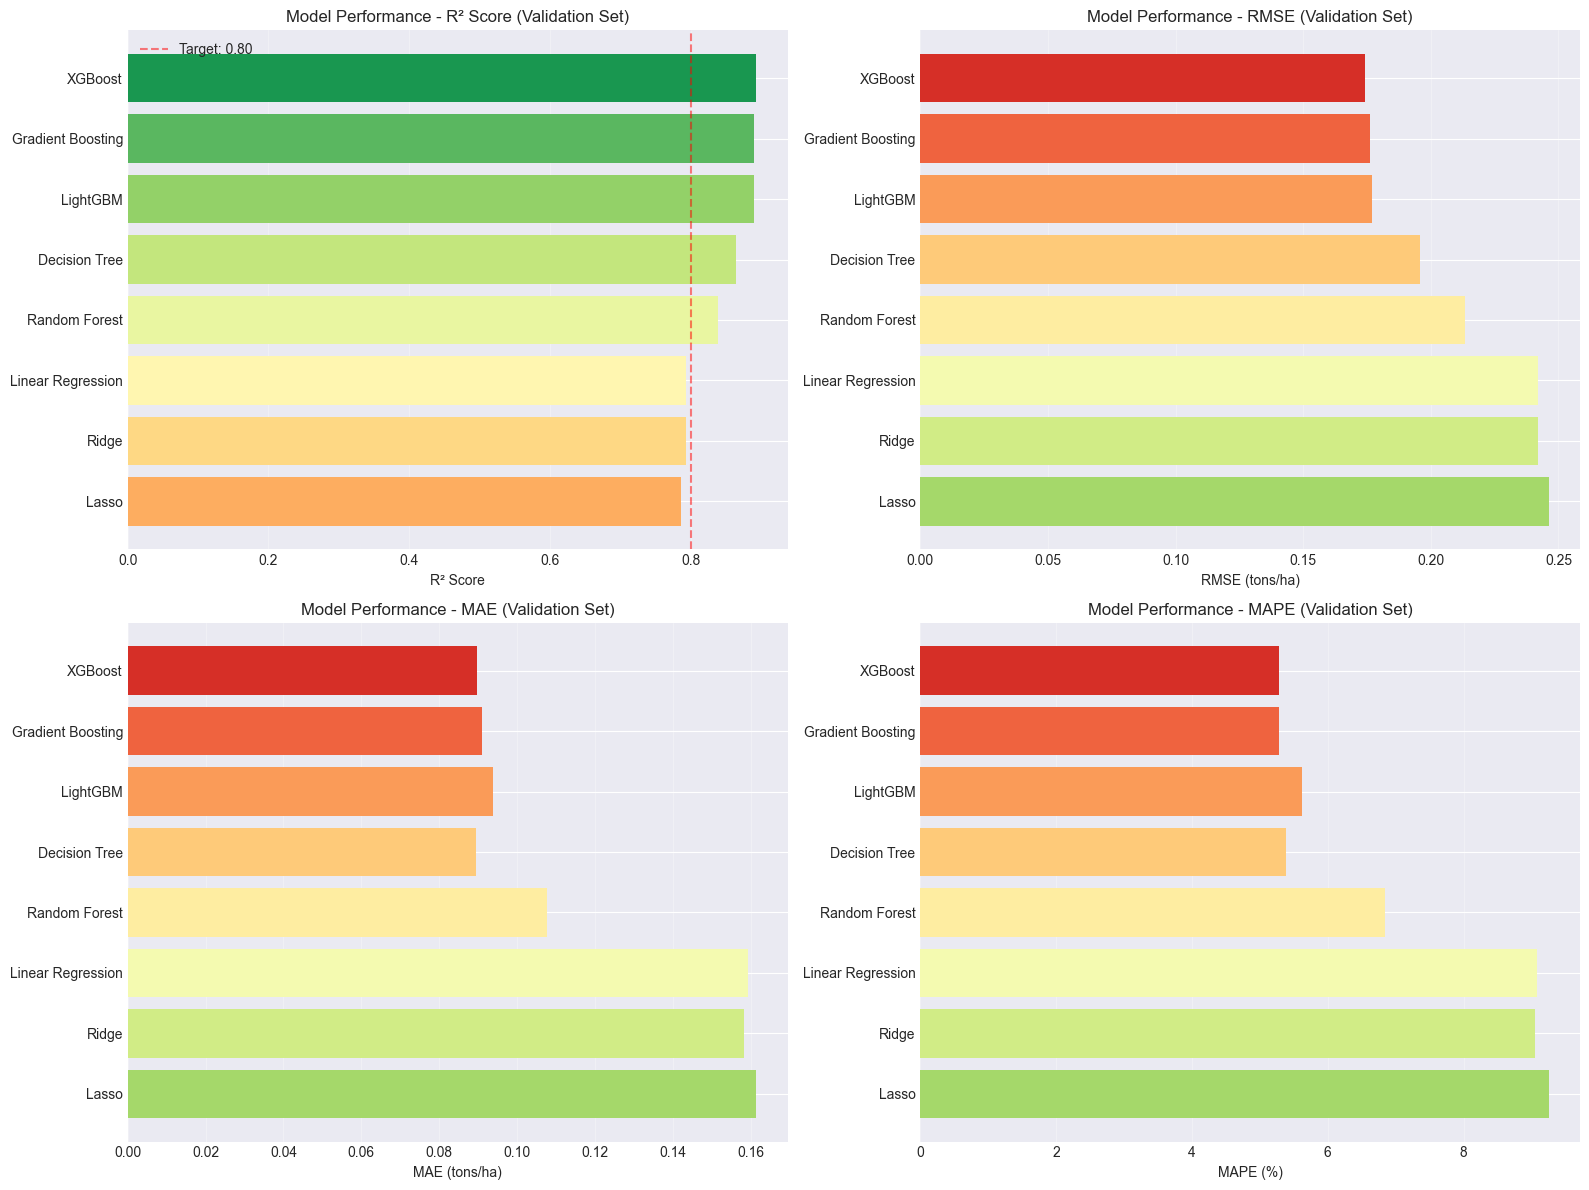

In [30]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
val_results_sorted = val_results.sort_values('R2', ascending=True)

# 1. R² Score
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(val_results_sorted)))
ax1.barh(val_results_sorted['Model_Name'], val_results_sorted['R2'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Model Performance - R² Score (Validation Set)')
ax1.axvline(0.8, color='red', linestyle='--', alpha=0.5, label='Target: 0.80')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. RMSE
ax2 = axes[0, 1]
colors_rmse = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(val_results_sorted)))
ax2.barh(val_results_sorted['Model_Name'], val_results_sorted['RMSE'], color=colors_rmse)
ax2.set_xlabel('RMSE (tons/ha)')
ax2.set_title('Model Performance - RMSE (Validation Set)')
ax2.grid(True, alpha=0.3, axis='x')

# 3. MAE
ax3 = axes[1, 0]
ax3.barh(val_results_sorted['Model_Name'], val_results_sorted['MAE'], color=colors_rmse)
ax3.set_xlabel('MAE (tons/ha)')
ax3.set_title('Model Performance - MAE (Validation Set)')
ax3.grid(True, alpha=0.3, axis='x')

# 4. MAPE
ax4 = axes[1, 1]
ax4.barh(val_results_sorted['Model_Name'], val_results_sorted['MAPE'], color=colors_rmse)
ax4.set_xlabel('MAPE (%)')
ax4.set_title('Model Performance - MAPE (Validation Set)')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


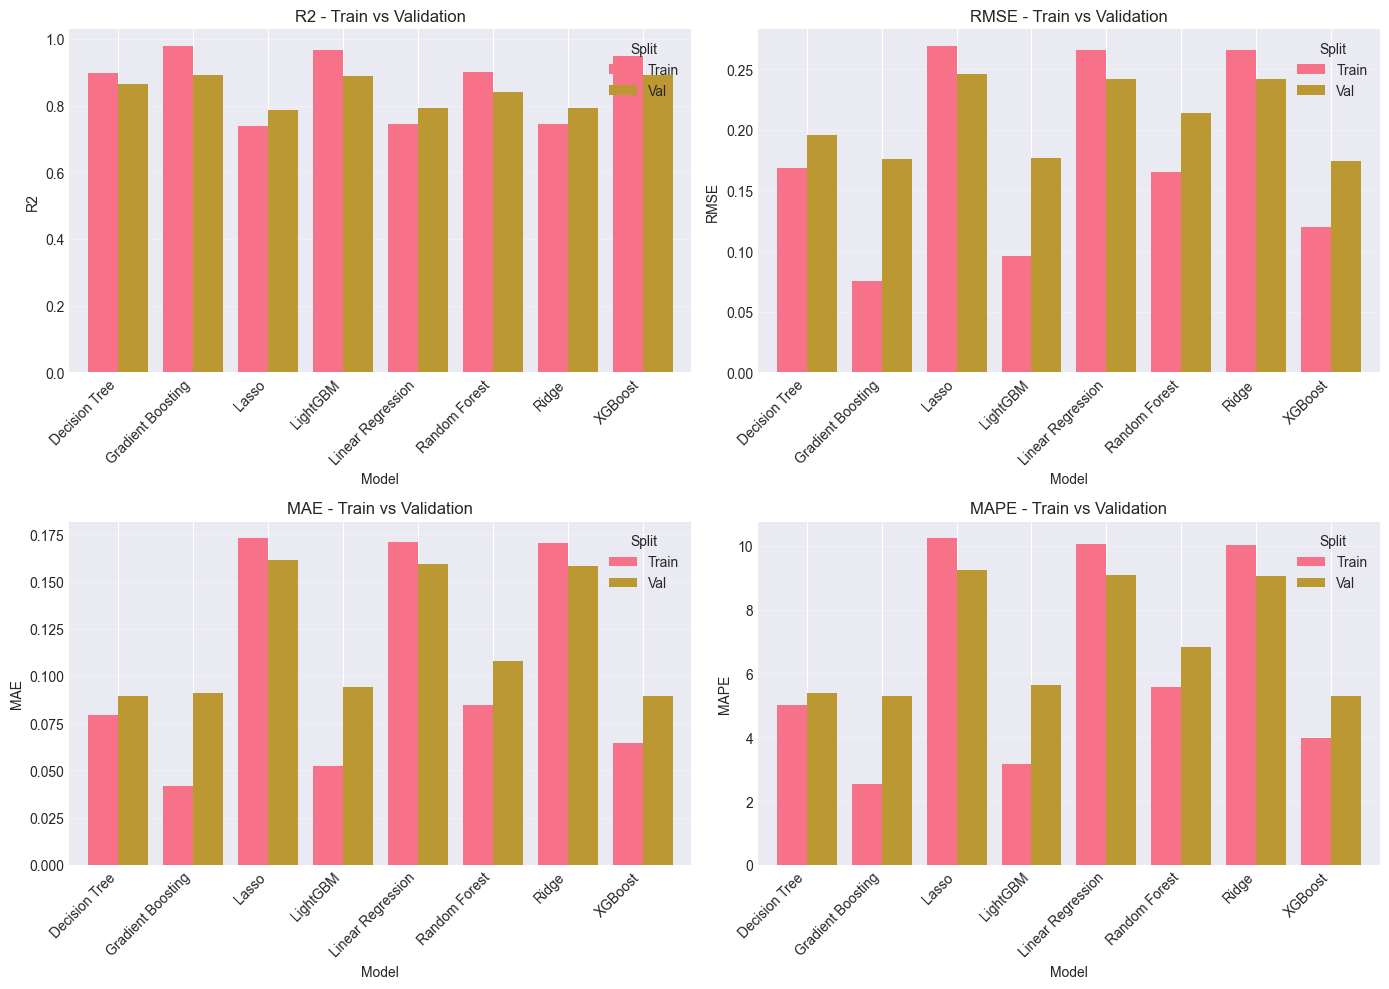

In [31]:
# Train vs Validation comparison (check for overfitting)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_compare = ['R2', 'RMSE', 'MAE', 'MAPE']
for idx, metric in enumerate(metrics_compare):
    ax = axes[idx // 2, idx % 2]
    
    pivot_data = results_df.pivot(index='Model_Name', columns='Split', values=metric)
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_title(f'{metric} - Train vs Validation')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.legend(title='Split', loc='best')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 8. Best Model Selection and Test Set Evaluation

In [32]:
print("=" * 80)
print("BEST MODEL SELECTION")
print("=" * 80)

# Select best model based on validation R²
best_model_name = val_results.iloc[0]['Model_Name']
best_val_r2 = val_results.iloc[0]['R2']

print(f"\nBest Model: {best_model_name}")
print(f"   Validation R²: {best_val_r2:.4f}")

# Get the best model
model_mapping = {
    'Linear Regression': lr_model,
    'Ridge': ridge_model,
    'Lasso': lasso_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

best_model = model_mapping[best_model_name]


BEST MODEL SELECTION

Best Model: XGBoost
   Validation R²: 0.8932


In [33]:
# Evaluate on test set
print("\n" + "=" * 80)
print("TEST SET EVALUATION")
print("=" * 80)

# Determine if model needs scaled data
scaled_models = ['Linear Regression', 'Ridge', 'Lasso']
if best_model_name in scaled_models:
    test_pred = best_model.predict(X_test_scaled)
    y_test_eval = y_test_scaled
else:
    test_pred = best_model.predict(X_test)
    y_test_eval = y_test

test_metrics = evaluate_model(y_test_eval, test_pred, f"{best_model_name} (Test)")
print_metrics(test_metrics)


TEST SET EVALUATION

Model                          RMSE         MAE          R²           MAPE        
XGBoost (Test)                 0.1612       0.0883       0.8930       5.64        %


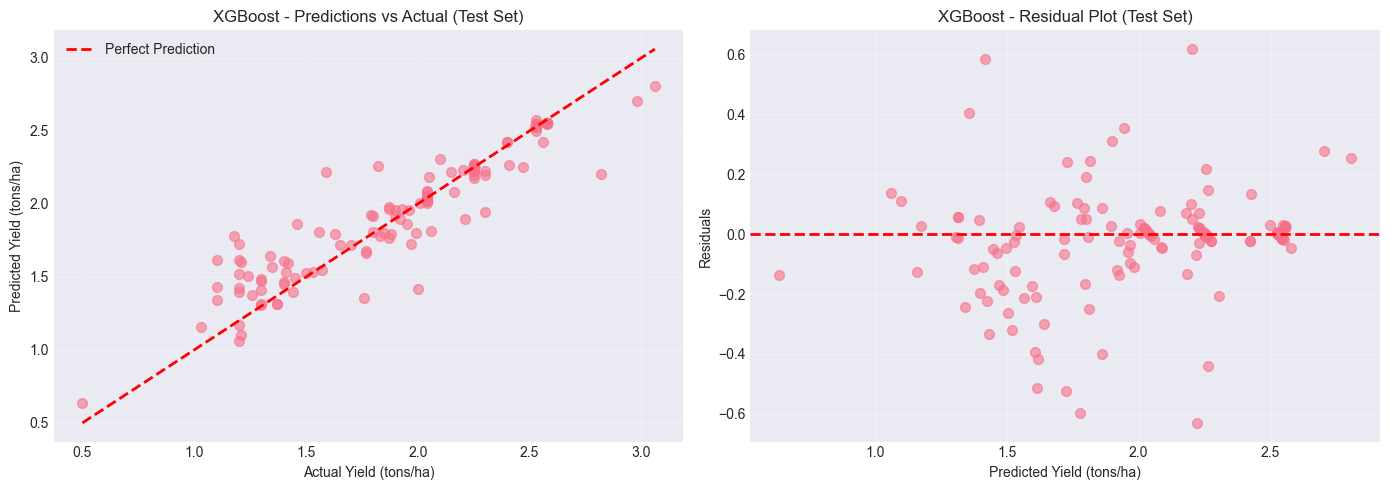

In [34]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test_eval, test_pred, alpha=0.6, s=50)
axes[0].plot([y_test_eval.min(), y_test_eval.max()], 
             [y_test_eval.min(), y_test_eval.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Yield (tons/ha)')
axes[0].set_ylabel('Predicted Yield (tons/ha)')
axes[0].set_title(f'{best_model_name} - Predictions vs Actual (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test_eval - test_pred
axes[1].scatter(test_pred, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Yield (tons/ha)')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{best_model_name} - Residual Plot (Test Set)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

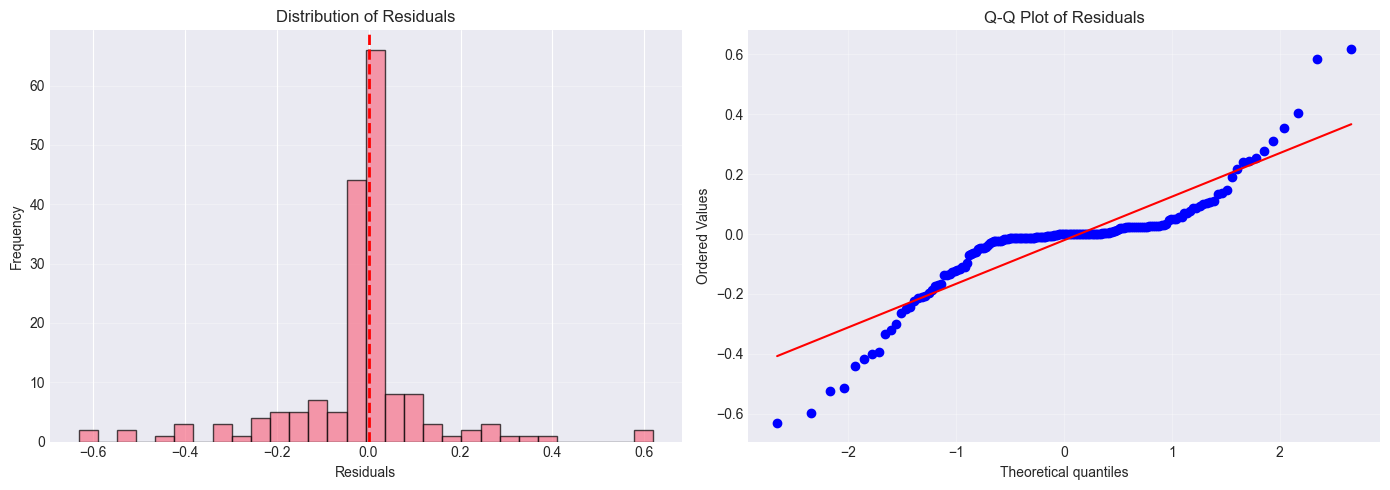


Residual Statistics:
  Mean: -0.0202
  Std Dev: 0.1604
  Min: -0.6305
  Max: 0.6181


In [35]:
# Distribution of residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')
axes[0].grid(True, alpha=0.3, axis='y')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std Dev: {residuals.std():.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")

## 9. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
              Feature  Importance
      Years_Since_PFJ    0.421713
           Yield_Lag1    0.190938
           PFJ_Policy    0.074821
       Pest_Soil_Risk    0.054833
 Temp_Sun_Interaction    0.039730
       Climate_Stress    0.030282
            Pest_Risk    0.028258
             Humidity    0.024109
   Water_Availability    0.019136
Rainfall_per_Moisture    0.015702


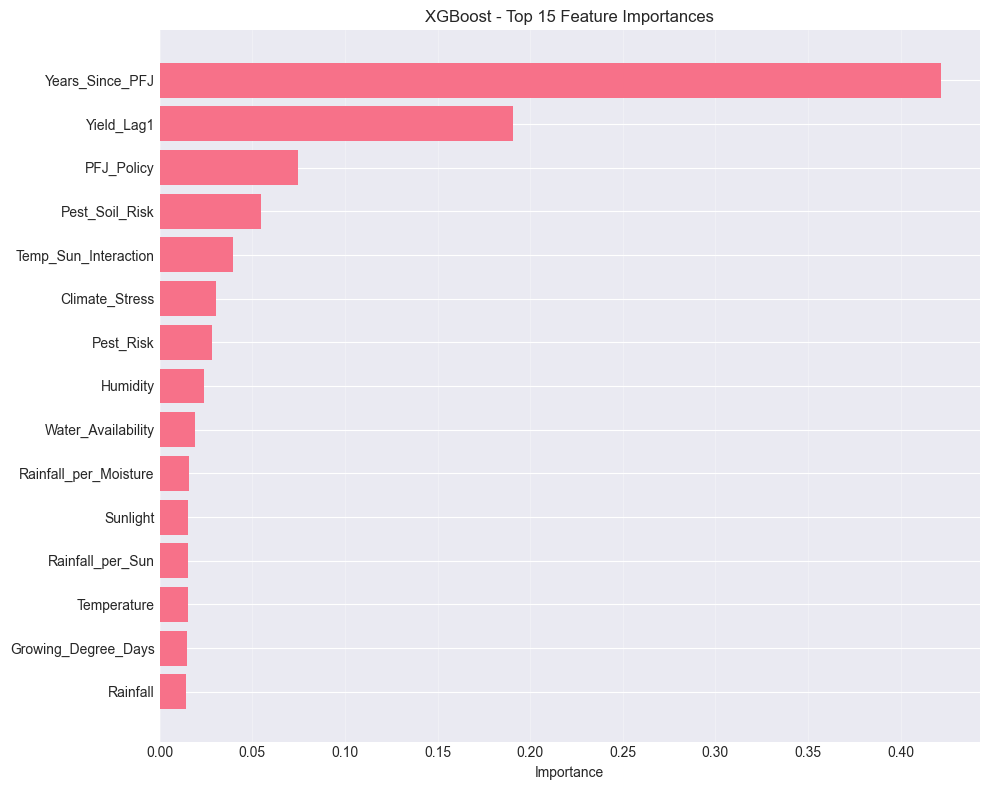

In [36]:
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_n = 15
    top_features = feature_importance.head(top_n)
    
    ax.barh(range(len(top_features)), top_features['Importance'])
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'{best_model_name} - Top {top_n} Feature Importances')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nSelected model doesn't support feature importance")


## 10. Save Best Model

In [37]:
print("=" * 80)
print("SAVING BEST MODEL")
print("=" * 80)

# Create models directory
models_dir = Path('../models/trained')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_filename = f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, models_dir / model_filename)
print(f"Model saved: {models_dir / model_filename}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_used': features,
    'n_features': len(features),
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'test_metrics': {
        'RMSE': float(test_metrics['RMSE']),
        'MAE': float(test_metrics['MAE']),
        'R2': float(test_metrics['R2']),
        'MAPE': float(test_metrics['MAPE'])
    },
    'hyperparameters': best_model.get_params() if hasattr(best_model, 'get_params') else {}
}

metadata_filename = f'model_metadata_{best_model_name.lower().replace(" ", "_")}.json'
with open(models_dir / metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Metadata saved: {models_dir / metadata_filename}")

# Save all results
results_filename = 'all_model_results.csv'
results_df.to_csv(models_dir / results_filename, index=False)
print(f"All results saved: {models_dir / results_filename}")

SAVING BEST MODEL
Model saved: ..\models\trained\best_model_xgboost.pkl
Metadata saved: ..\models\trained\model_metadata_xgboost.json
All results saved: ..\models\trained\all_model_results.csv


## 11. Model Performance Summary

In [38]:
summary = f"""
{'=' * 80}
MODEL TRAINING SUMMARY
{'=' * 80}

BEST MODEL: {best_model_name}

TEST SET PERFORMANCE:
  - R² Score:  {test_metrics['R2']:.4f}
  - RMSE:      {test_metrics['RMSE']:.4f} tons/ha
  - MAE:       {test_metrics['MAE']:.4f} tons/ha
  - MAPE:      {test_metrics['MAPE']:.2f}%

MODELS TRAINED:
  1. Linear Regression
  2. Ridge Regression
  3. Lasso Regression
  4. Decision Tree
  5. Random Forest
  6. Gradient Boosting
  7. XGBoost
  8. LightGBM

DATASET INFO:
  - Training samples:   {len(X_train):,}
  - Validation samples: {len(X_val):,}
  - Test samples:       {len(X_test):,}
  - Features used:      {len(features)}

FILES SAVED:
  ✓ Model: {model_filename}
  ✓ Metadata: {metadata_filename}
  ✓ Results: {results_filename}

{'=' * 80}
MODEL TRAINING COMPLETE!
{'=' * 80}

NEXT STEPS:
  1. Review feature importance
  2. Perform hyperparameter tuning (optional)
  3. Create model evaluation report
  4. Deploy model to API
  5. Build frontend dashboard
"""

print(summary)

# Save summary to docs
docs_dir = Path('../docs')
docs_dir.mkdir(parents=True, exist_ok=True)
with open(docs_dir / 'model_training_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)
print(f"\nSummary saved: {docs_dir / 'model_training_summary.txt'}")



MODEL TRAINING SUMMARY

BEST MODEL: XGBoost

TEST SET PERFORMANCE:
  - R² Score:  0.8930
  - RMSE:      0.1612 tons/ha
  - MAE:       0.0883 tons/ha
  - MAPE:      5.64%

MODELS TRAINED:
  1. Linear Regression
  2. Ridge Regression
  3. Lasso Regression
  4. Decision Tree
  5. Random Forest
  6. Gradient Boosting
  7. XGBoost
  8. LightGBM

DATASET INFO:
  - Training samples:   1,241
  - Validation samples: 355
  - Test samples:       178
  - Features used:      19

FILES SAVED:
  ✓ Model: best_model_xgboost.pkl
  ✓ Metadata: model_metadata_xgboost.json
  ✓ Results: all_model_results.csv

MODEL TRAINING COMPLETE!

NEXT STEPS:
  1. Review feature importance
  2. Perform hyperparameter tuning (optional)
  3. Create model evaluation report
  4. Deploy model to API
  5. Build frontend dashboard


Summary saved: ..\docs\model_training_summary.txt
